In [7]:
from SonicBatt import utils
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FormatStrFormatter

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'degradation')
data_path = os.path.join(study_path, 'Raw Data')
visualistion_path = os.path.join(study_path, 'Visualisation')

database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
test_id = database.loc[database['test_type']=='temp_variation']
test_id = test_id['test_id'].iloc[0]
test_dir = os.path.join(data_path, test_id)


In [3]:
parquet_filename = '{}_cycling.parquet'.format(test_id)
parquet_filepath = os.path.join(data_path, test_id, parquet_filename)
df_cycling = pq.read_table(parquet_filepath).to_pandas()

df = utils.df_with_peaks(data_path, test_id, passes=50)

# Voltage recording finishes earlier than acoustic and temperature.
# Find the index
filter = df['cycling']['V(V)'].diff() != 0
v_final_index = df.loc[filter].index[-1]


Smoothing signals. Passes = 50. Window_len = 15
-----------------
0.00 %
10.00 %
20.00 %
30.00 %
40.00 %
50.00 %
60.00 %
70.00 %
80.00 %
90.00 %


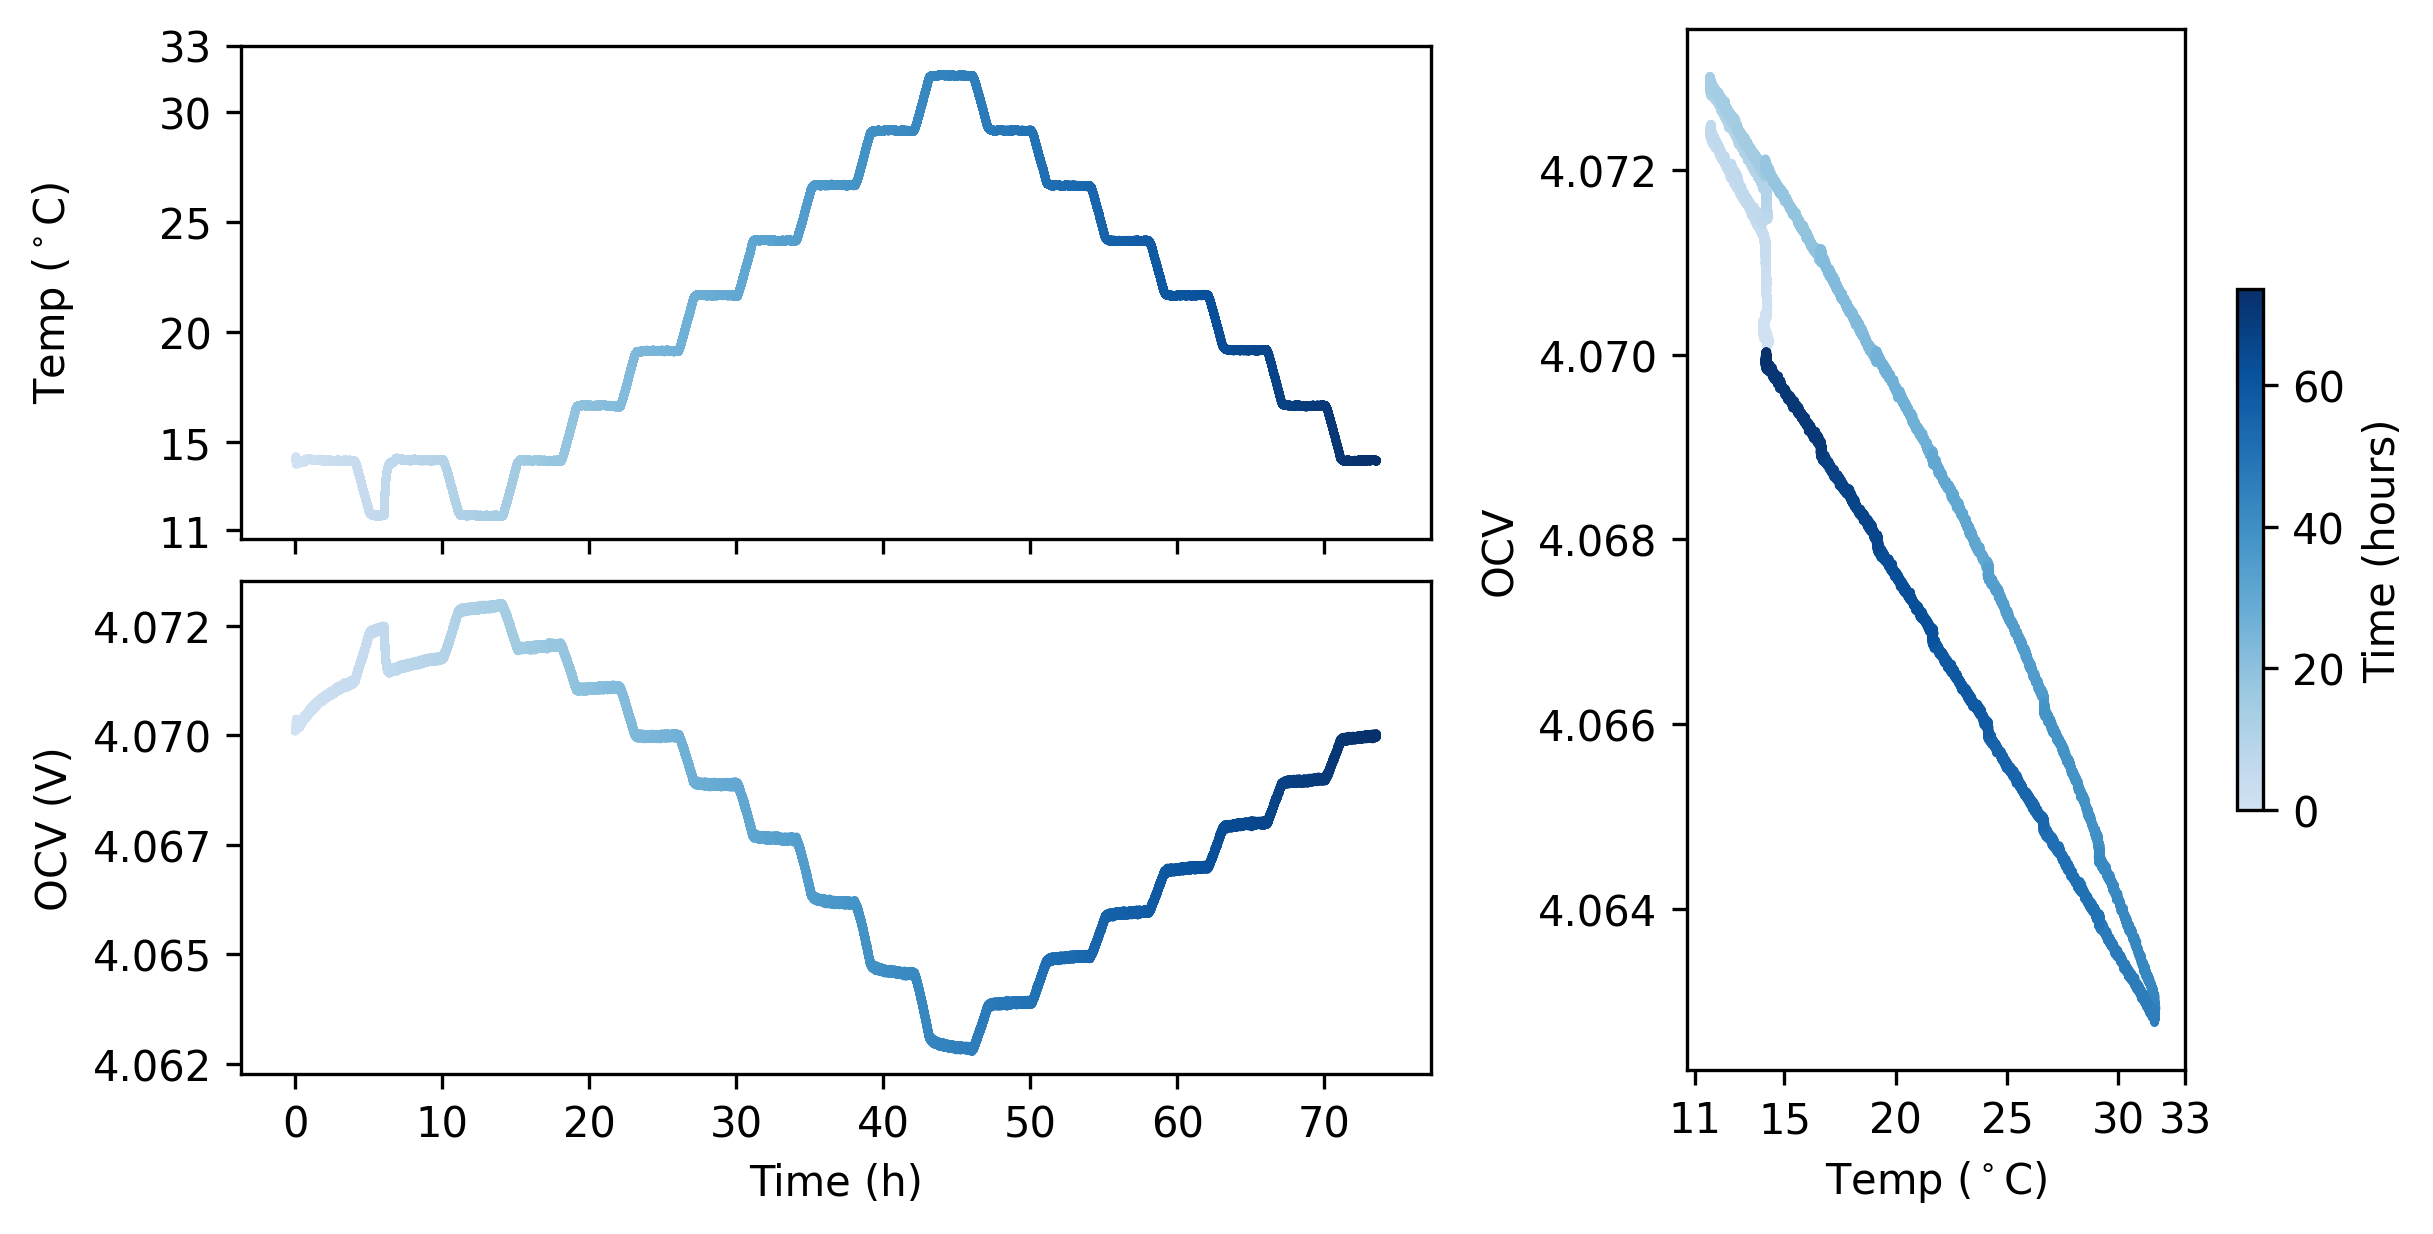

In [8]:
# Equilibrium plot: OCV-Temperature
time_h = df_cycling['Time(s)'].to_numpy()/3600
norm = mpl.colors.Normalize(
    vmin=min(time_h), vmax=max(time_h))
time_colorsheme = ListedColormap(cm.Blues(np.linspace(0.2, 1, 256)))
temp_tick_locs = [11, 15, 20, 25, 30, 33]

f = plt.figure(figsize=(8,4), constrained_layout=True, dpi=300)
f.patch.set_facecolor('white')
subfigs = f.subfigures(1, 2, hspace=0.02, width_ratios=[1.5, 1])
axs_1 = subfigs[0].subplots(2, 1, sharex=True)
axs_2 = subfigs[1].subplots(1, 1)

c = time_colorsheme(norm(time_h))
s=1
axs_1[0].scatter(time_h, df_cycling['Temp(degC)'], c=c, s=s)
axs_1[1].scatter(time_h, df_cycling['V(V)'], c=c, s=s)
axs_2.scatter(df_cycling['Temp(degC)'], df_cycling['V(V)'], c=c, s=s)

cb = f.colorbar(cm.ScalarMappable(norm=norm, cmap=time_colorsheme), ax=axs_2, 
            location='right', aspect=20, shrink=0.5)
cb.set_label(label='Time (hours)', size=10)

axs_1[0].set_ylabel('Temp ($^\circ$C)')
axs_1[1].set_ylabel('OCV (V)')
axs_1[1].set_xlabel('Time (h)')
axs_2.set_xlabel('Temp ($^\circ$C)')
axs_2.set_ylabel('OCV')
axs_1[0].set_yticks(temp_tick_locs)
axs_2.set_xticks(temp_tick_locs)
axs_1[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

subfigs[0].align_ylabels()

save_filename = 'Temp_variation_at_OCV_V-T'
utils.save_figure(f, visualistion_path, save_filename, 'png')


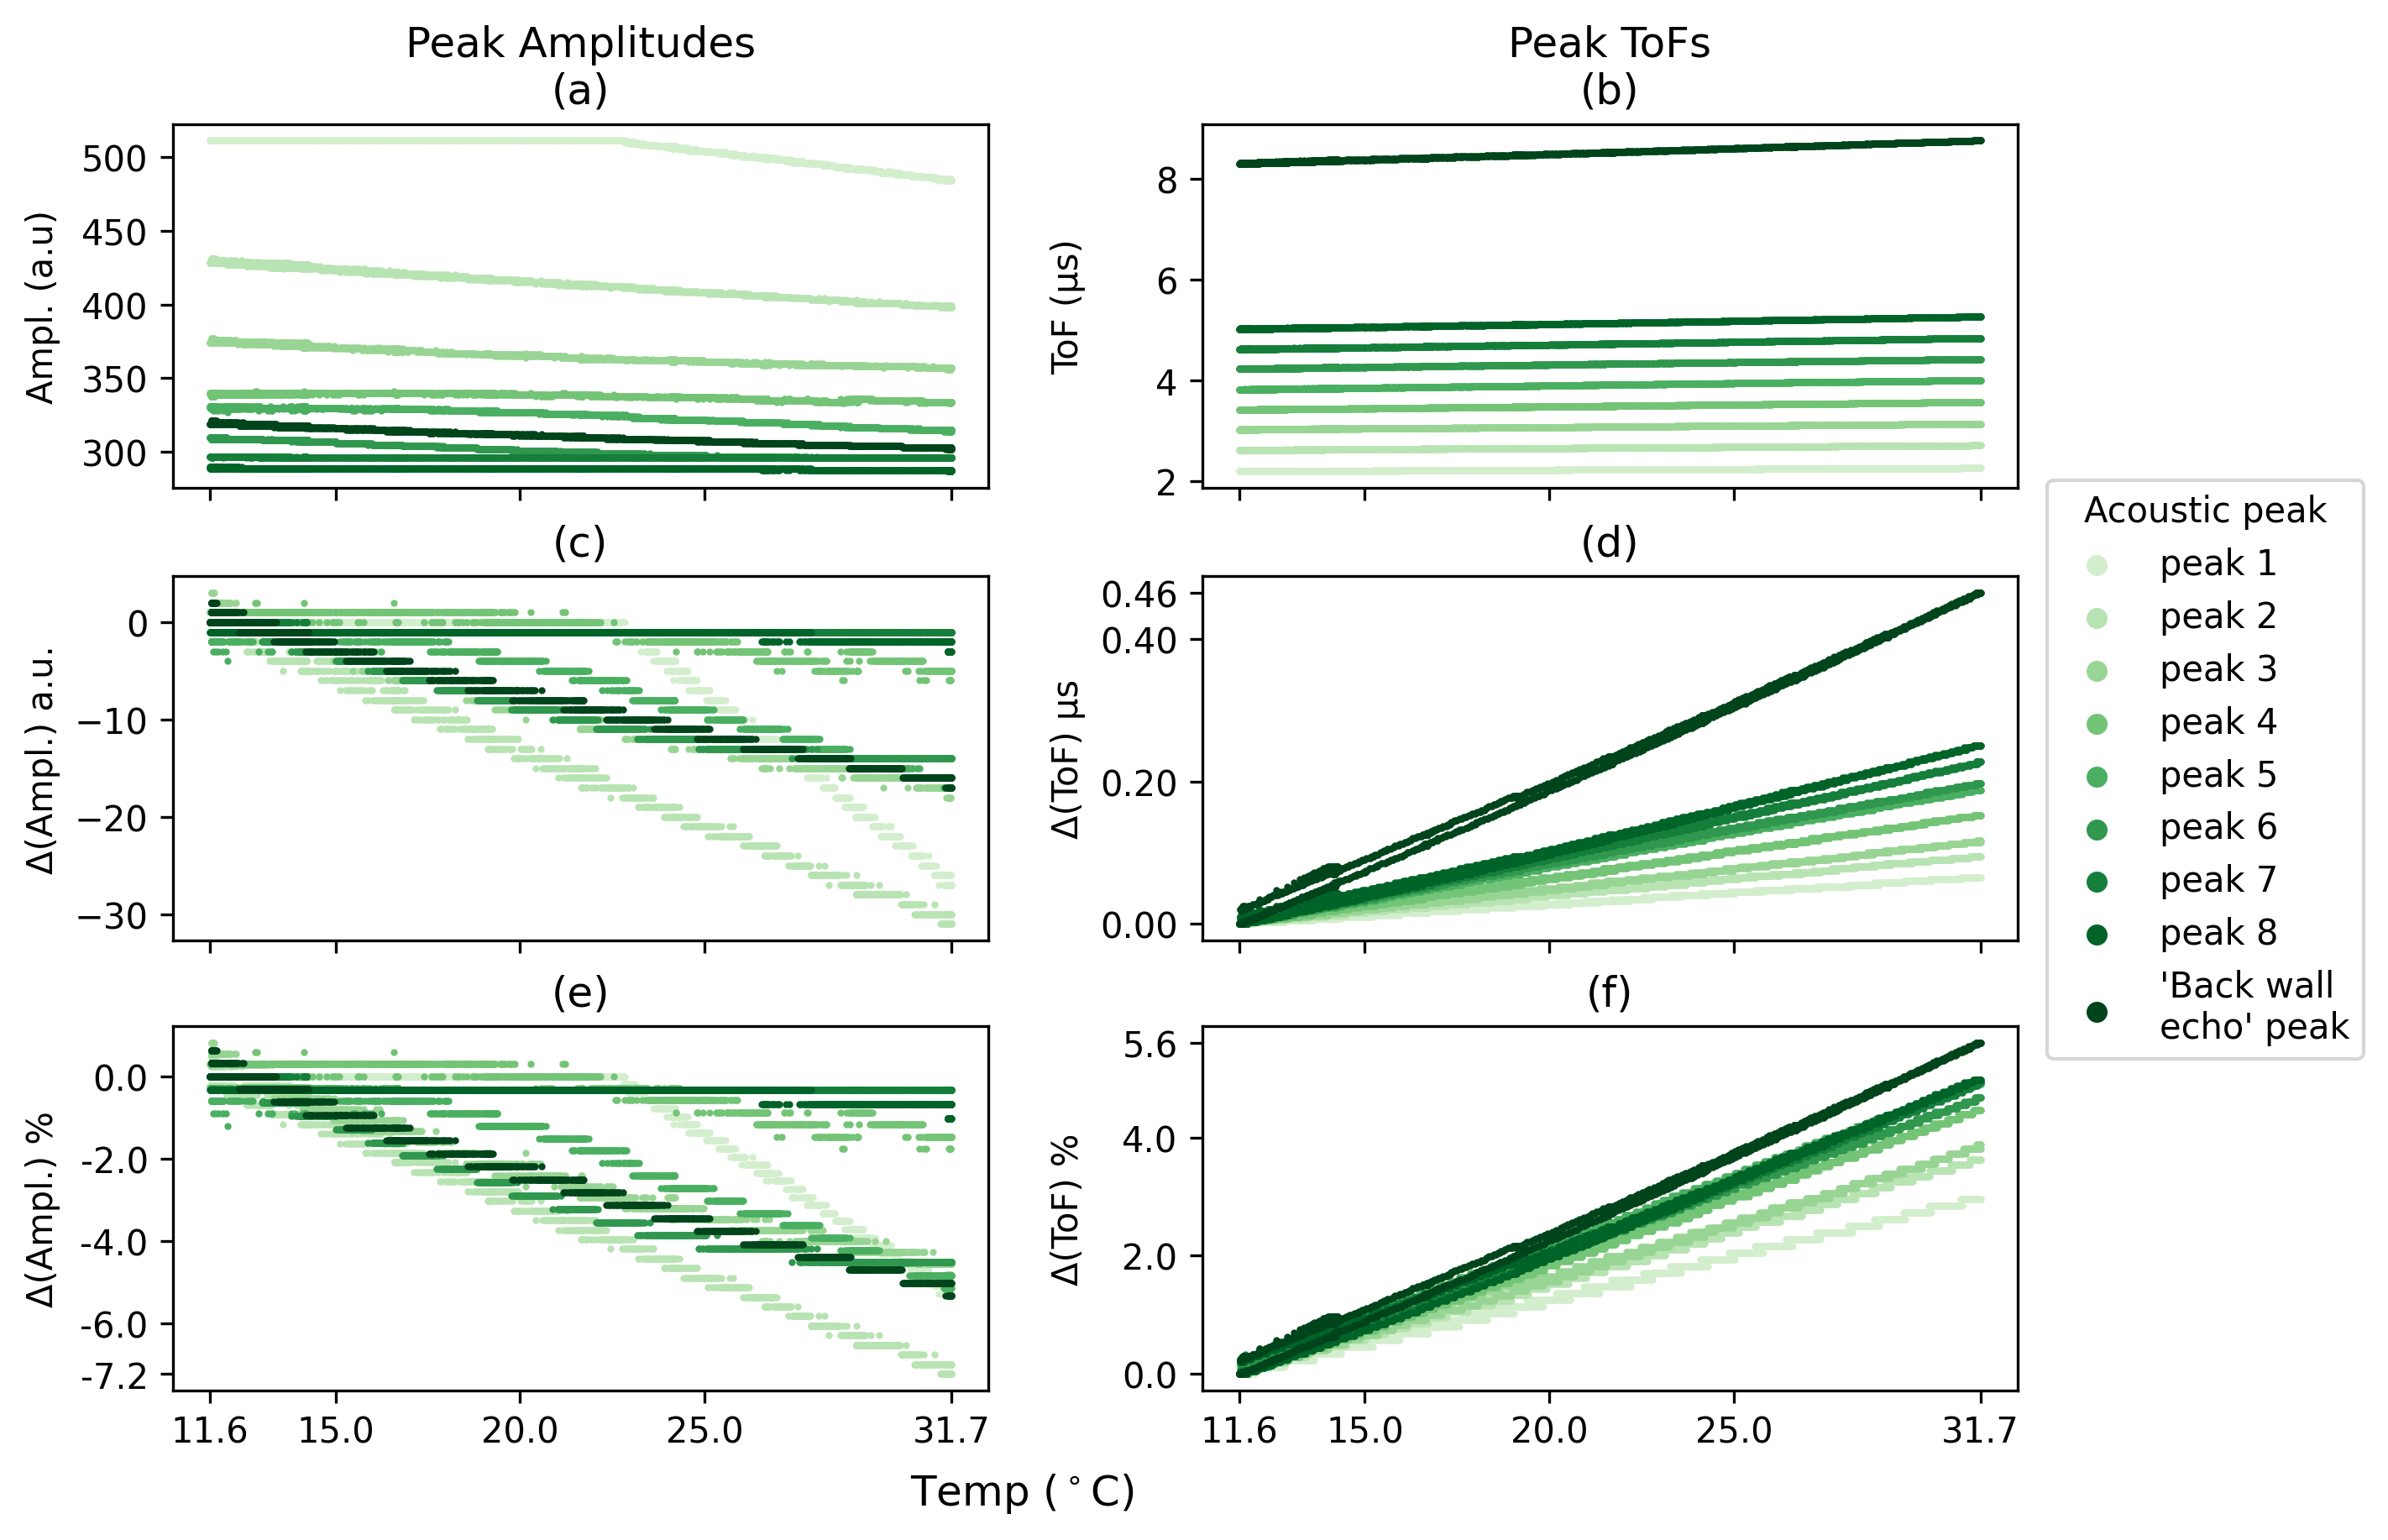

In [4]:
# Equilibrium plots: Acoustics-Temperature
n_peaks = 9
s=1
norm = mpl.colors.Normalize(vmin=0, vmax=8)
peaks_colorscheme = ListedColormap(cm.Greens(np.linspace(0.2, 1, 256)))
filter = df['cycling']['Temp(degC)']==df['cycling']['Temp(degC)'].min()
min_temp_index = df.loc[filter].index[0]
# Find some minima while looping:
min_delta_pct_ampl = 100
max_delta_tof_pct = -100
max_delta_tof = -100
f, axs = plt.subplots(3,2,figsize=(8,6), dpi=300, constrained_layout=True, sharex=True,
                       gridspec_kw={'wspace': 0.06})
for i in range(n_peaks):
    c = peaks_colorscheme(norm(i))
    #
    axs[0][0].scatter(
        df['cycling']['Temp(degC)'], df['peak_heights'][str(i)],
        s=s, color=c)
    delta_ampl = df['peak_heights'][str(i)]-df['peak_heights'][str(i)].loc[min_temp_index]
    axs[1][0].scatter(
        df['cycling']['Temp(degC)'], delta_ampl,
        s=s, color=c)
    delta_pct_ampl = delta_ampl/df['peak_heights'][str(i)].loc[min_temp_index] * 100
    axs[2][0].scatter(
        df['cycling']['Temp(degC)'], delta_pct_ampl,
        s=s, color=c)
    #
    if delta_pct_ampl.min() < min_delta_pct_ampl:
        min_delta_pct_ampl = delta_pct_ampl.min()
    #
    axs[0][1].scatter(
        df['cycling']['Temp(degC)'], df['peak_tofs'][str(i)],
        s=s, color=c)
    delta_tof = df['peak_tofs'][str(i)]-df['peak_tofs'][str(i)].loc[min_temp_index]
    axs[1][1].scatter(
        df['cycling']['Temp(degC)'], delta_tof,
        s=s, color=c)
    delta_tof_pct = delta_tof/df['peak_tofs'][str(i)].loc[min_temp_index] * 100
    axs[2][1].scatter(
        df['cycling']['Temp(degC)'], delta_tof_pct,
        s=s, color=c)
    #
    if delta_tof_pct.max() > max_delta_tof_pct:
        max_delta_tof_pct = delta_tof_pct.max()
    if delta_tof.max() > max_delta_tof:
        max_delta_tof = delta_tof.max()
    #
axs[0][0].set_title('Peak Amplitudes\n(a)')
axs[0][1].set_title('Peak ToFs\n(b)')
axs[1][0].set_title('(c)')
axs[1][1].set_title('(d)')
axs[2][0].set_title('(e)')
axs[2][1].set_title('(f)')

axs[0][0].set_ylabel('Ampl. (a.u)')
axs[0][1].set_ylabel('ToF (μs)')
axs[1][0].set_ylabel('Δ(Ampl.) a.u.')
axs[1][1].set_ylabel('Δ(ToF) μs')
axs[2][0].set_ylabel('Δ(Ampl.) %')
axs[2][1].set_ylabel('Δ(ToF) %')
#
min_temp = df['cycling']['Temp(degC)'].min()
max_temp = df['cycling']['Temp(degC)'].max()
from matplotlib.ticker import FormatStrFormatter
for j in range(2):
    axs[-1][j].set_xticks([min_temp, 15, 20, 25, max_temp])
    axs[-1][j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#
axs[2][0].set_yticks([min_delta_pct_ampl, -6, -4, -2, 0])
axs[2][1].set_yticks([0, 2, 4, max_delta_tof_pct])
axs[-1][0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[-1][1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#
axs[1][1].set_yticks([0, 0.2, 0.4, max_delta_tof])
axs[1][1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#
for i in range(n_peaks):
    c = peaks_colorscheme(norm(i))
    if i < (n_peaks-1):
        label = 'peak {}'.format(i+1)
    else:
        label = "'Back wall\necho' peak"
    axs[0][0].scatter(
        df['cycling']['Temp(degC)'].iloc[-1], df['peak_heights'][str(i)].iloc[-1],
        s=s, color=c, label=label)

f.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Acoustic peak",
         markerscale=5)
f.align_ylabels()
f.supxlabel('Temp ($^\circ$C)')

save_filename = 'Temp_variation_at_OCV_Deltas'
utils.save_figure(f, visualistion_path, save_filename, 'png')
